# Genetic run analysis - StateVector

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from quake.models.qsvm import genetic_v3 as genetic
from quake.models.qsvm.genetic_v3 import to_quantum
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from collections import OrderedDict
from qiskit.circuit import ParameterVector
from qiskit.circuit import QuantumCircuit
import pandas as pd
import csv
import pygad
from qiskit_ibm_provider import IBMProvider

In [347]:
# Loading cross validation data
# First 500 entries: actual CV set
# Last 500 entries: test set that will be used later
data_cv_tot, data_labels_tot = np.load("C:/Users/pc/Desktop/work/data_1000.npy"), np.load("C:/Users/pc/Desktop/work/labels_1000.npy")
nb_features = data_cv_tot.shape[1]
data_cv = data_cv_tot[:500]
data_labels = data_labels_tot[:500]

In [348]:
# Classical SVM Benchmarking
# We optimize a Gaussian (RBF) though a grid search (5-folds)

# Define the SVM model with RBF kernel
svm = SVC(kernel='rbf')

# Set up the parameter grid for hyperparameters C and gamma
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 20000, 100000],
    'gamma': [1e-2, 1e-3, 1e-4, 1e-5, 'scale', 'auto']
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=3, n_jobs=-1)

# Fit the model
grid_search.fit(data_cv, data_labels)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Use the best estimator to make predictions
best_svm = grid_search.best_estimator_
predictions = best_svm.predict(data_cv)

avg_accuracy = cross_val_score(
                best_svm,
                data_cv,
                data_labels,
                cv=5,
                scoring="accuracy",
            ).mean()
print("Best classical accuracy (fold average):", avg_accuracy)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters found: {'C': 10000, 'gamma': 'auto'}
Best cross-validation score: 0.624
Best classical accuracy (fold average): 0.624


In [349]:
# We load the results from a genetic run
study_type = "2024_05_24 -10_06_56" # other supported: 
suffix = "2024_05_24 -10_06_56"

# _05_24 -00_47_12 is 0.01, the one after that is 0

genes = pd.read_csv("../../Output_genetic/"+study_type+"/genes" +
                 suffix+".csv", header=None, index_col=False).to_numpy()

df_fitnesses = pd.read_csv("../../Output_genetic/"+study_type+"/fitness_values_iter_" +
                 suffix+".csv", header=None, index_col=False).to_numpy().reshape(-1)
# df_kernels = pd.read_csv("../../Output_genetic/"+suffix +
#                          "/kernels_flattened"+suffix+".csv", header=None, index_col=False)
accuracies = np.loadtxt("../../Output_genetic/" +
                        study_type+"/accuracy"+suffix+".txt")
sparsities = np.loadtxt("../../Output_genetic/" +
                        study_type+"/sparsity"+suffix+".txt")
stds = np.loadtxt("../../Output_genetic/"+study_type+"/offdiagonal_std_"+suffix+".txt")
gen_id = np.loadtxt("../../Output_genetic/"+study_type+"/generation_id"+suffix+".txt")

# Vary this according to your run input
n_epochs = 250
keep_elitism = 0
pop_size = 50
num_parents_mating = 20

In [350]:
# Helper function that returns the indices related to the best kernels in a generation
def get_champions(previous_gen_fitness, keep_elitism):
    if keep_elitism > 0:
        ascending_order_idx = np.argsort(previous_gen_fitness)
        top_n_indices = ascending_order_idx[-keep_elitism:]
        top_n_indices = top_n_indices[::-1]
        return top_n_indices
    else:
        return None

In [351]:
# Group all data into np.ndarrays (kernel_id_in_generation, nb_generation)
if keep_elitism > 0:
    grouped_fitness = np.zeros((251, pop_size))
    grouped_accuracies = np.zeros((251, pop_size))
    grouped_stds = np.zeros((251, pop_size))

    grouped_fitness[0] = df_fitnesses[:pop_size]
    grouped_accuracies[0] = accuracies[:pop_size]
    grouped_stds[0] = stds[:pop_size]
    for i in range(1, n_epochs+1):
        elite_idxes = get_champions(grouped_fitness[i-1], keep_elitism)
        idx = np.argwhere(gen_id == i)
        grouped_fitness[i, :keep_elitism + len(idx)] = np.concatenate([grouped_fitness[i-1][elite_idxes], df_fitnesses[idx].reshape(-1)])
        grouped_accuracies[i, :keep_elitism + len(idx)] = np.concatenate([grouped_accuracies[i-1][elite_idxes], accuracies[idx].reshape(-1)])
        grouped_stds[i, :keep_elitism + len(idx)] = np.concatenate([grouped_stds[i-1][elite_idxes], stds[idx].reshape(-1)])
else:
    grouped_fitness = np.zeros((251, pop_size - num_parents_mating))
    grouped_accuracies = np.zeros((251, pop_size - num_parents_mating))
    grouped_stds = np.zeros((251, pop_size - num_parents_mating))
    for i in range(1, n_epochs+1):
        idx = np.argwhere(gen_id == i)
        grouped_fitness[i, :len(idx)] = df_fitnesses[idx].reshape(-1)
        grouped_accuracies[i, :len(idx)] = accuracies[idx].reshape(-1)
        grouped_stds[i, :len(idx)] = stds[idx].reshape(-1)

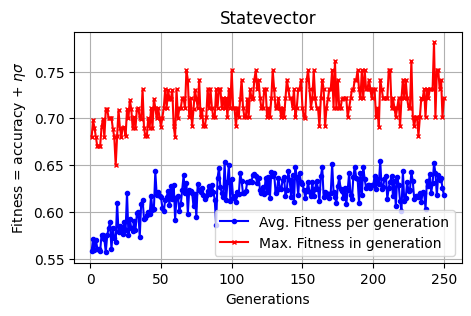

In [352]:
# Fitness function across generations

non_zero_mask = grouped_fitness != 0
# Use the mask to ignore zero entries while computing the mean along axis 1
mean_without_zeros = np.ma.masked_array(grouped_fitness, mask=~non_zero_mask).mean(axis=1)
max_without_zeros = np.ma.masked_array(grouped_fitness, mask=~non_zero_mask).max(axis=1)

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(mean_without_zeros, label='Avg. Fitness per generation', linestyle='-', marker='o', color='b', markersize=3)
plt.plot(max_without_zeros, label='Max. Fitness in generation', linestyle='-', marker='x', color='r', markersize=3)

# Adding labels and title
plt.xlabel('Generations')
plt.ylabel(r'Fitness = accuracy + $\eta\sigma$')
plt.title('Statevector')

# Adding legend
plt.legend()

# Adding grid
plt.grid(True)

# Save the plot
# plt.savefig("../../" + study_type + "_fitness.svg", bbox_inches='tight')

# Show plot
plt.show()

In [353]:
sss

NameError: name 'sss' is not defined

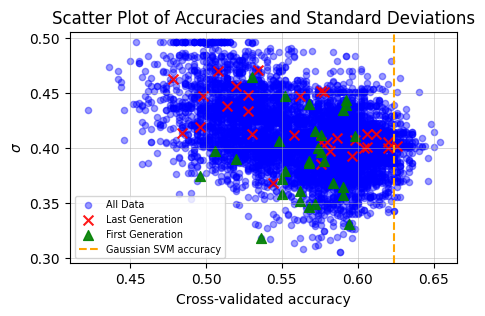

In [ ]:
plt.figure(figsize=(5, 3))

# Scatter plot for all accuracies and stds
plt.scatter(accuracies, stds, label='All Data', color='b', marker='o', s=20, alpha=0.4)

# Scatter plot for the last generation
plt.scatter(grouped_accuracies[-1, :], grouped_stds[-1, :], label='Last Generation', color='r', marker='x', s=50, alpha=0.9)

# Scatter plot for the first generation
plt.scatter(grouped_accuracies[1, :], grouped_stds[1, :], label='First Generation', color='g', marker='^', s=50, alpha=0.9)
plt.axvline(x=0.624, color='orange', linestyle='--', label='Gaussian SVM accuracy')

# Adding labels and title
plt.xlabel('Cross-validated accuracy')
plt.ylabel(r'$\sigma$')
plt.title('Scatter Plot of Accuracies and Standard Deviations')

# Adding legend in the lower left
plt.legend(loc='lower left', fontsize='x-small')

# Adding grid
plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)

# Save the plot
#plt.savefig("../../" + study_type + "_acc_sigma.svg", bbox_inches='tight')

# Show plot
plt.show()

In [ ]:
gate_dict = OrderedDict(
    [
        ("single_non_parametric", ["Id", "H", "X", "SX"]),
        ("single_parametric", ["RX", "RY", "RZ"]),
        ("two_non_parametric", ["CX"]),
        ("two_parametric", ["CRX", "CRY", "CRZ"]),
    ]
)

In [ ]:
fittest_kernel_id = np.argmax(df_fitnesses)
fittest_kernel_accuracy = accuracies[fittest_kernel_id]
fittest_kernel_sparsity = sparsities[fittest_kernel_id]
fittest_kernel_stds = stds[fittest_kernel_id]
print(f"Best kernel found after {fittest_kernel_id} iterations")
print(f"Best kernel accuracy: {fittest_kernel_accuracy}")
print(f"Best kernel sparsity: {fittest_kernel_sparsity}")
print(f"Best kernel std: {fittest_kernel_stds}")

Best kernel found after 9296 iterations
Best kernel accuracy: 0.6940000000000001
Best kernel sparsity: 0.009404579709830663
Best kernel std: 0.3065188167982449


In [ ]:
features_per_fmap = []
fmaps = []
for i in range(genes.shape[0]):
    fmap, x_idxs = to_quantum(np.array(genes[i]), gate_dict=gate_dict, nb_features=18, gates_per_qubits=8, nb_qubits=4)
    fmaps.append(fmap)
    features_per_fmap.append(x_idxs)

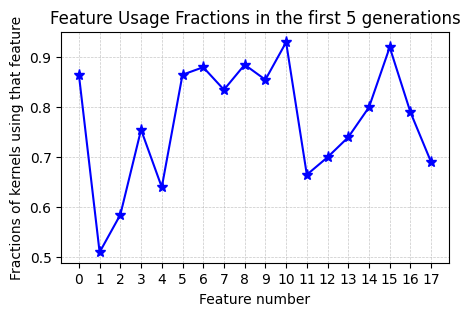

In [ ]:
feature_counter = np.zeros(18)
for x_idxs in features_per_fmap[:50+30*5]:
    for i in range(18):
        if i in x_idxs:
            feature_counter[i] += 1
plt.figure(figsize=(5, 3))  # Adjust the figure size as needed

# Plot with customized line and markers
plt.plot(np.arange(0, 18), feature_counter / (50+30*5), "-*", color='b', markersize=8, linewidth=1.5)

# Adding labels
plt.ylabel("Fractions of kernels using that feature")
plt.xlabel("Feature number")

# Setting x-ticks to integers only
plt.xticks(np.arange(0, 18, 1))

# Adding grid
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding title
plt.title("Feature Usage Fractions in the first 5 generations")

plt.savefig("../../" + study_type + "_init_ft.svg", bbox_inches = "tight")
# Show plot
plt.show()

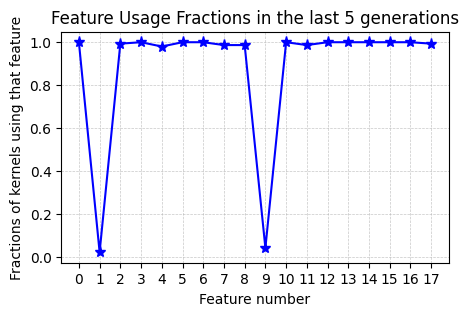

In [ ]:
feature_counter = np.zeros(18)
for x_idxs in features_per_fmap[-30*5:]:
    for i in range(18):
        if i in x_idxs:
            feature_counter[i] += 1
plt.figure(figsize=(5, 3))  # Adjust the figure size as needed

# Plot with customized line and markers
plt.plot(np.arange(0, 18), feature_counter / (30*5), "-*", color='b', markersize=8, linewidth=1.5)

# Adding labels
plt.ylabel("Fractions of kernels using that feature")
plt.xlabel("Feature number")

# Setting x-ticks to integers only
plt.xticks(np.arange(0, 18, 1))

# Adding grid
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adding title
plt.title("Feature Usage Fractions in the last 5 generations")
plt.savefig("../../" + study_type + "_last_ft.svg", bbox_inches = "tight")

# Show plot
plt.show()

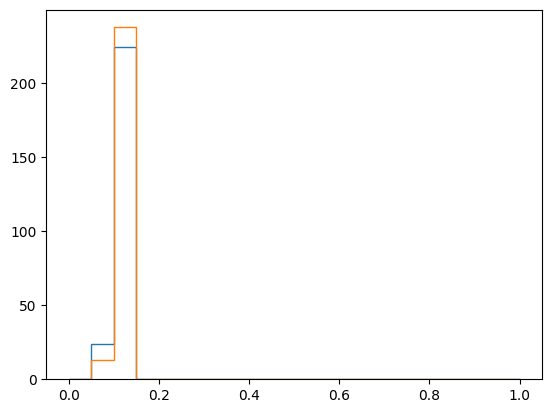

In [ ]:
ft_id = 1
plt.hist(data_cv[data_labels == 0, ft_id], range = [0., 1], histtype="step", bins = 20)[-1]
plt.hist(data_cv[data_labels == 1, ft_id], range = [0., 1], histtype="step", bins = 20)[-1]

In [ ]:
scaler = MinMaxScaler((0, 1))
scaler.data_min_ = np.array([-1.5707864, -1.5707864, -1.5707864, -1.5707864, -1.5671399,
       -1.5707864, -1.4798536, -1.5707864, -1.5707862, -1.5707864,
       -1.5701118, -1.4552664, -1.5707864, -1.5652468, -1.5707864,
       -1.5707864, -1.4777324, -1.5707864])
scaler.data_max_ = np.array([1.5707866, 1.5707862, 1.5707862, 1.3299273, 1.5707862, 1.5707865,
       1.5707865, 1.5707864, 1.5707865, 1.5707865, 1.5707861, 1.5707865,
       1.5707865, 1.5707862, 1.5707864, 1.5707864, 1.5707864, 1.5707862],
      )
scaler.data_range_ = np.array([3.141573 , 3.1415725, 3.1415725, 2.9007137, 3.137926 , 3.141573 ,
       3.05064  , 3.1415727, 3.1415727, 3.141573 , 3.1408978, 3.026053 ,
       3.141573 , 3.136033 , 3.1415727, 3.1415727, 3.0485187, 3.1415725],
      )
scaler.scale_ = np.array([0.31831187, 0.31831193, 0.31831193, 0.34474275, 0.3186818 ,
       0.31831187, 0.32780007, 0.3183119 , 0.3183119 , 0.31831187,
       0.3183803 , 0.33046347, 0.31831187, 0.31887418, 0.3183119 ,
       0.3183119 , 0.32802817, 0.31831193])
scaler.min_ = np.array([0.49999994, 0.50000006, 0.50000006, 0.5415172 , 0.49941897,
       0.49999994, 0.48509613, 0.5       , 0.49999994, 0.49999994,
       0.49989265, 0.48091236, 0.49999994, 0.4991168 , 0.5       ,
       0.5       , 0.48473787, 0.50000006])

In [ ]:
# data, labels = np.load("C:/Users/pc/Desktop/work/full_dataset.npy"), np.load("C:/Users/pc/Desktop/work/full_labels.npy")
# data = scaler.transform(data)

# mask = np.all((data >= -1) & (data <= 1), axis=1)

# # Use the mask to filter out samples that have any feature values outside the range [-1, 1]
# data = data[mask]

# data_retrain = data[:400]
# labels_retrain = labels[:400]
data_test = data_cv_tot[500:]
labels_test = data_labels_tot[500:]

best_fmap = fmaps[fittest_kernel_id]
best_x_idxs = features_per_fmap[fittest_kernel_id]

In [ ]:
from qiskit_aer import StatevectorSimulator
from qiskit_machine_learning.kernels import FidelityStatevectorKernel

backend = StatevectorSimulator(precision='double')
clf = SVC(kernel="precomputed", C = 1)
qker = FidelityStatevectorKernel(feature_map=best_fmap)

qker_matrix_retrain = qker.evaluate(x_vec=data_cv[:, x_idxs])
accuracy_cv = cross_val_score(
    clf, qker_matrix_retrain, data_labels, cv=5, scoring="accuracy"
).mean()
print(accuracy_cv)

qker_matrix_test = qker.evaluate(y_vec=data_cv[:, x_idxs], x_vec=data_test[:, x_idxs])
clf.fit(qker_matrix_retrain, data_labels)
accuracy_test = clf.score(qker_matrix_test, labels_test)
print(accuracy_test)

0.6719999999999999
0.618


In [ ]:
best_svm.fit(data_cv,  data_labels)
best_svm.score(data_test, labels_test)

0.586

In [ ]:
best_svm.C

10000

In [ ]:
from qiskit_machine_learning.kernels import FidelityStatevectorKernel
from quake.utils.utils import load_runcard, save_runcard
from quake.models.autoencoder.autoencoder_dataloading import read_data
from quake.models.autoencoder.train import load_and_compile_network
import numpy as np
from pathlib import Path
from quake.models.qsvm.qsvm_tester import get_features

from quake.models.qsvm import genetic_v3 as genetic

from qiskit import Aer

import time

# Dataset loading
data_folder = Path("../../output_2/data")
train_folder = Path("../../output_2/models/autoencoder")
setup = load_runcard("../../output_2/cards/runcard.yaml")
setup["run_tf_eagerly"] = True
setup["seed"] = 42

dataset, labels = get_features(data_folder.parent, "autoencoder", setup)
scaler = MinMaxScaler((0, 1)).fit(dataset[0])
data_cv, data_labels = genetic.get_subsample(
    dataset[2], labels[2], 20, scaler=scaler)
nb_features = data_cv.shape[1]

nb_features = data_cv.shape[1]

[INFO] (quake.autoencoder) Loading splitting maps from folder: ..\..\output_2\models\autoencoder
INFO:quake.autoencoder:Loading splitting maps from folder: ..\..\output_2\models\autoencoder
[INFO] (quake.autoencoder) Train dataset balancing: 125517 training points, of which 50.12% positives
INFO:quake.autoencoder:Train dataset balancing: 125517 training points, of which 50.12% positives
[INFO] (quake.autoencoder) Validation dataset balancing: 26897 training points, of which 49.77% positives
INFO:quake.autoencoder:Validation dataset balancing: 26897 training points, of which 49.77% positives
[INFO] (quake.autoencoder) Test dataset balancing: 26897 training points, of which 49.74% positives
INFO:quake.autoencoder:Test dataset balancing: 26897 training points, of which 49.74% positives
[INFO] (quake.autoencoder) Loading weights at ..\..\output_2\models\autoencoder\autoencoder.h5
INFO:quake.autoencoder:Loading weights at ..\..\output_2\models\autoencoder\autoencoder.h5


   1/4184 [..............................] - ETA: 8:07

KeyboardInterrupt: 

In [ ]:
from qiskit_aer import StatevectorSimulator


In [ ]:
# kernels = df_kernels.to_numpy().reshape(21, 100,100)
data_cv, data_labels = np.load("C:/Users/pc/Desktop/work/data_cv.npy"), np.load("C:/Users/pc/Desktop/work/data_labels.npy")
useful_ft = [0, 1,2,5,6, 8, 10, 12, 14, 15, 17]

data_cv = data_cv[:, useful_ft]

In [ ]:
acc_real = []
for i in range(21):
    qker_matrix = kernels[:,:,i]


    clf = SVC(kernel="precomputed")

    # param_grid = {"C": [0.01, 0.1, 1, 10, 100, 1000, 10000]}
    # grid_search = GridSearchCV(clf, param_grid, cv=4, scoring="accuracy")
    # grid_search.fit(qker_matrix, data_labels)
    # best_clf = grid_search.best_estimator_
    accuracy_cv = cross_val_score(
        clf, qker_matrix, data_labels, cv=4, scoring="accuracy"
    )
    print(i)
    print(best_clf)
    print(accuracy_cv.mean())
    acc_real.append(accuracy_cv.mean())

In [ ]:
qsvm_connections = [
    [0,1,2,3],
    [4,15,22,21],
    [25,26,16,8],
    [13,12,11,10],
    [20, 33,39,38],
    [27,28,29,30],
    [32,36,51,50],
    [40,41,53,60],
    [49,48,47,46],
    # [71,58,57,56],
    [64,63,62,72],
    [70,69,68,67],
    [77,78,79,80],
    [82,83,84,85],
    [87,88,89,74],
    [95,94,90,75],
    [96,97,98,99],
    [119,118,110,100],
    [104,105,106,93],
    [116,115,114,113],
    [111,122,121,120],
    [126,125,124,123]
]

In [ ]:
data_cv, data_labels = np.load("C:/Users/pc/Desktop/work/data_cv.npy"), np.load("C:/Users/pc/Desktop/work/data_labels.npy")


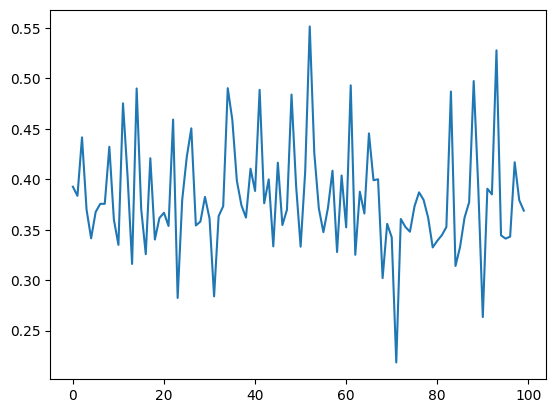

In [ ]:
plt.hist(data_cv[:, 0])[]

In [ ]:
from qiskit_machine_learning.kernels import FidelityStatevectorKernel
data_cv, data_labels = np.load("C:/Users/pc/Desktop/work/data_cv.npy"), np.load("C:/Users/pc/Desktop/work/data_labels.npy")
useful_ft = [0, 1,2,5,6, 8, 10, 12, 14, 15, 17]

data_cv = data_cv[:, useful_ft]
acc_statevec = []
for i in range(21):
    fmap, x_idxs = to_quantum(np.array(genes[i]), gate_dict=gate_dict, nb_features=11, gates_per_qubits=6, nb_qubits=4, param_shift=0, physical_qubits = qsvm_connections[rand_idxs[i]],coupling_map=coupling_map)

    backend = StatevectorSimulator(precision='single')

    qker = FidelityStatevectorKernel(feature_map=fmap)
    qker_matrix = qker.evaluate(x_vec=data_cv[:, x_idxs])


    clf = SVC(kernel="precomputed", C = 1)

    # param_grid = {"C": [0.01, 0.1, 1, 10, 100, 1000, 10000]}
    # param_grid = {"C": [1]}

    # grid_search = GridSearchCV(clf, param_grid, cv=4, scoring="accuracy")
    # grid_search.fit(qker_matrix, data_labels)
    # best_clf = grid_search.best_estimator_
    accuracy_cv = cross_val_score(
        clf, qker_matrix, data_labels, cv=4, scoring="accuracy"
    )
    print(clf)
    print(accuracy_cv.mean())
    acc_statevec.append(accuracy_cv.mean())


[126, 125, 124, 123] for qubit 124 I did nothing
SVC(C=1, kernel='precomputed')
0.53
SVC(C=1, kernel='precomputed')
0.53
[27, 28, 29, 30] for qubit 29 I did nothing
[27, 28, 29, 30] for qubit 29 I did nothing
[27, 28, 29, 30] for qubit 29 I did nothing
SVC(C=1, kernel='precomputed')
0.49
SVC(C=1, kernel='precomputed')
0.69
SVC(C=1, kernel='precomputed')
0.5900000000000001
[96, 97, 98, 99] for qubit 98 I did nothing
SVC(C=1, kernel='precomputed')
0.5
SVC(C=1, kernel='precomputed')
0.53
SVC(C=1, kernel='precomputed')
0.5900000000000001
[32, 36, 51, 50] for qubit 51 I did nothing
SVC(C=1, kernel='precomputed')
0.53
SVC(C=1, kernel='precomputed')
0.58
SVC(C=1, kernel='precomputed')
0.6000000000000001
[4, 15, 22, 21] for qubit 22 I did nothing
[4, 15, 22, 21] for qubit 22 I did nothing
SVC(C=1, kernel='precomputed')
0.53
SVC(C=1, kernel='precomputed')
0.53
SVC(C=1, kernel='precomputed')
0.53
[111, 122, 121, 120] for qubit 121 I did nothing
[111, 122, 121, 120] for qubit 121 I did nothing
SV

In [ ]:
plt.plot([acc_real[int(r)] for r in rand_idxs])
plt.plot(acc_statevec)

NameError: name 'acc_real' is not defined

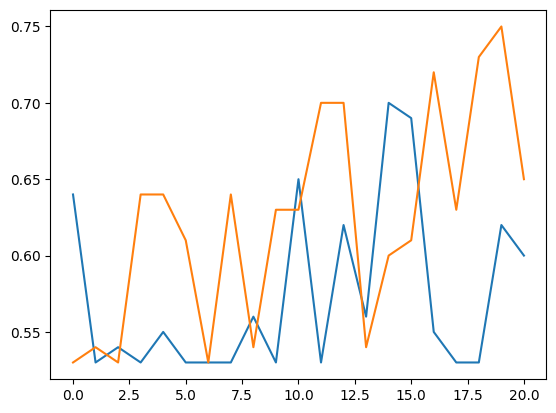

In [ ]:
plt.plot(acc_real)
plt.plot(acc_statevec)

In [ ]:
rand_idxs

array([20,  6, 17, 13,  8,  2, 11,  1, 14,  5,  0, 16, 18,  9, 19,  7,  4,
       10,  3, 12, 15], dtype=int64)

In [ ]:
rand_idxs

array([[20,  6, 17, 13,  8,  2, 11,  1, 14,  5,  0, 16, 18,  9, 19,  7,
         4, 10,  3, 12, 15]], dtype=int64)

In [ ]:
genes[0]

array([ 0,  1,  1,  7,  1,  0,  2,  1,  7,  8,  4,  2,  1,  1,  7,  1,  0,
        1,  4,  6,  2,  0,  0,  9,  8,  1,  0,  1,  4,  9,  4,  2,  0,  1,
        4,  2,  2,  0,  3,  8,  2,  0,  1,  2,  9,  2,  1,  1,  0,  8,  3,
        1,  1,  0,  6,  3,  1,  0,  3,  0,  2,  1,  0,  4,  6,  3,  0,  0,
        6,  2,  4,  1,  1,  7,  3,  3,  0,  1,  6,  1,  0,  0,  1,  7,  3,
        3,  0,  1,  6,  2,  4,  2,  1,  1,  0,  3,  0,  0, 10,  2,  1,  2,
        1,  0,  1,  2,  0,  0,  8,  7,  1,  1,  1,  2,  9,  1,  0,  0,  0,
        6,  2,  2,  0,  6,  0,  1,  2,  0, 10,  6,  2,  2,  1,  8,  7,  2,
        1,  1,  2,  5,  2,  1,  0,  7,  3,  1,  1,  1,  8,  3,  0,  0,  0,
        6,  3,  1,  0,  1,  4,  3,  4,  2,  1,  2,  7,  3,  2,  1,  7,  3,
        2,  1,  1,  8,  4,  4,  2,  0,  6,  8], dtype=int64)

In [ ]:
from qiskit_aer import AerSimulator


SyntaxError: invalid syntax (1906777400.py, line 1)

In [ ]:
data_cv, data_labels = np.load("C:/Users/pc/Desktop/work/data_cv.npy"), np.load("C:/Users/pc/Desktop/work/data_labels.npy")

# Performance on a different, preliminar test set, simply by changing the seed in get_subsample(). Some overlap with the set training set could still occurr!
# Note: We train the model again.
data_test, data_labels_test = genetic.get_subsample(
    dataset[2], labels[2], 500, scaler=scaler, seed=1234)

qker_test = qker.evaluate(x_vec=data_test[:, x_idxs])

param_grid = {"C": [0.01, 0.1, 1, 10, 100, 1000, 10000]}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy")
grid_search.fit(qker_test, data_labels_test)
best_clf_test = grid_search.best_estimator_
accuracy_test = cross_val_score(
    best_clf_test, qker_test, data_labels_test, cv=5, scoring="accuracy"
)
print(best_clf)
print(accuracy_test.mean())

In [37]:
from qiskit_aer import StatevectorSimulator
from qiskit_machine_learning.kernels import FidelityStatevectorKernel
import numpy as np

data_cv, data_labels = np.load("C:/Users/pc/Desktop/work/data_cv.npy"), np.load("C:/Users/pc/Desktop/work/data_labels.npy")
useful_ft = [0, 5, 6, 8, 10, 12, 14, 15]
data_cv = data_cv[:, useful_ft]
from quake.models.qsvm.genetic_v3 import to_quantum
from sklearn.svm import SVC
from collections import OrderedDict

backend = StatevectorSimulator(precision='double')
clf = SVC(kernel="precomputed", C = 1)
gate_dict = OrderedDict(
    [
        ("single_non_parametric", ["Id", "X","SX"]),
        ("single_parametric", ["RZ", "RZ"]),
        ("two_non_parametric", ["CZ"]),
        ("two_parametric", []),
    ]
)
genes = [3, 0, 1, 2, 5, 2, 1, 0, 1, 6, 3, 2, 1, 0, 2, 4, 1, 1, 0, 4, 5, 1,
       1, 5, 2, 2, 1, 1, 4, 1, 4, 2, 1, 3, 6, 4, 2, 1, 6, 3, 4, 0, 1, 3,
       1, 2, 0, 1, 0, 1, 1, 2, 1, 3, 1, 2, 2, 1, 4, 6, 5, 1, 0, 4, 2, 5,
       2, 1, 2, 1, 2, 0, 1, 0, 4, 2, 1, 1, 2, 7, 3, 0, 0, 0, 3, 3, 1, 1,
       3, 4, 1, 0, 0, 0, 5, 2, 2, 1, 0, 1, 0, 1, 0, 5, 6, 4, 0, 1, 2, 0,
       3, 1, 0, 0, 7, 4, 1, 0, 4, 6, 1, 1, 0, 3, 6, 1, 1, 1, 6, 7, 2, 0,
       1, 4, 3, 5, 2, 1, 7, 1, 1, 2, 0, 2, 1, 1, 0, 0, 3, 5, 3, 2, 1, 1,
       7, 3, 1, 0, 5, 4]
fmap, x_idxs = to_quantum(
    genes, gate_dict, len(useful_ft), 8, 4
)
qker = FidelityStatevectorKernel(feature_map=fmap)

qker_matrix_retrain = qker.evaluate(x_vec=data_cv[:, x_idxs])
accuracy_cv = cross_val_score(
    clf, qker_matrix_retrain, data_labels, cv=5, scoring="accuracy"
).mean()
print(accuracy_cv)

0.6


In [27]:
fmap